# Using DataChain for LLM evaluations

This notebook will show how to use DataChain for common LLM-judging-LLM cases, including how to:

- [Re-organizing text samples from CSV table](#ingesting)
- [Placing LLM API calls over input data](#processing)
- [Collecting Pydantic objects from LLM responses](#pydantic)
- [Comparative LLM analytics](#analytics)

## Setup

To start, install the dependencies and import the LLM packages. To run these examples, your will need an [API key from Mistral AI](https://console.mistral.ai/user/api-keys/ "Mistral console") (free) and [Anthropic](https://console.anthropic.com/login "Anthropic console") (paid). If you do not have an Anthropic key, these examples can be skipped.

In [2]:
!pip install datachain mistralai anthropic pydantic matplotlib scikit-learn
!export MISTRAL_API_KEY= <your API key here>
!export ANTHROPIC_API_KEY= <your API key here>

The history saving thread hit an unexpected error (OperationalError('attempt to write a readonly database')).History will not be written to the database.
  Using cached typing-3.7.4.3-py3-none-any.whl
/bin/bash: -c: line 0: syntax error near unexpected token `newline'
/bin/bash: -c: line 0: `export MISTRAL_API_KEY= <your API key here>'
/bin/bash: -c: line 0: syntax error near unexpected token `newline'
/bin/bash: -c: line 0: `export ANTHROPIC_API_KEY= <your API key here>'


In [1]:
import os

from datachain.lib.dc import Column, DataChain
from datachain.lib.data_model import DataModel

from pydantic import BaseModel


<a id='ingesting'></a>
## Organizing text samples 

We will be using a dataset from [Karlsruhe Institute of Technology](https://radar.kit.edu/radar/en/dataset/FdJmclKpjHzLfExE.ExpBot%2B-%2BA%2Bdataset%2Bof%2B79%2Bdialogs%2Bwith%2Ban%2Bexperimental%2Bcustomer%2Bservice%2Bchatbot) which captures interactions between human experiment participants and a simple chatbot programmed to offer them a new mobile service plan. 

Evaluating the performance of a chatbot with another LLM is a common workflow and a cornerstone of many agentic applications. The task here is to go over the recorded conversations and evaluate the chatbot performance. In our particular application, the original dataset is in CSV format, similar to the below:

| id | count | sender | text |
|----------|----------|----------|----------|
| 1 | 1 | bot | Hey there! |
| 1 | 2 | bot | I'm a chatbot that helps you find a new mobile phone plan. What can I do for you?|
| 1 | 3 |user | Hi :) I need a phone plan with more MB and less minutes |
| 1 | 4 |bot | Okay, let's start! First, I need some information about your current mobile phone plan: |

In the table above, every line corresponds to one utterance of the dialog. Lines sharing the "id" field belong to the same conversation.

For our purposes, we want to group all lines that belong to the same conversation into one text block to be read by an LLM. We can do this by first parsing the CSV file at the original storage location, and then using an aggregator to reformat CSV lines into a new data model:

In [2]:
class Dialog(BaseModel):
    id: int
    text: str

def text_block(id: str, sender: str, text: str) -> Dialog:
    columns = zip(text, sender)
    conversation = ""
    for text, sender in columns:
       conversation = "\n ".join([conversation,f"{sender}: {text}"])
    yield Dialog(id=id[0], text=conversation) 

chain = DataChain.from_csv("gs://datachain-demo/chatbot-csv/").agg(text_block, output={"dialog": Dialog}, partition_by="id").save()


Processed: 1 rows [00:00, 1098.85 rows/s]
Processed: 1 rows [00:00, 1072.99 rows/s]
Parsed by pyarrow: 3594 rows [00:00, 11879.73 rows/s]
Processed: 0 rows [00:00, ? rows/s]
Processed: 1 rows [00:00,  7.99 rows/s]
Generated: 3594 rows [00:00, 28853.54 rows/s]
Processed: 0 rows [00:00, ? rows/s]
Processed: 3594 rows [00:00, 61921.64 rows/s]
Generated: 79 rows [00:00, 1381.17 rows/s]


Now we should have collected 79 separate dialogs:

In [3]:
chain.count()

79

The schema for these dialogs should be provided by our Dialog class

In [4]:
chain.print_schema()

 dialog: Dialog
     id: int
     text: str


Finally, every dataset sample should capture the entire dialog as a text block:

In [4]:
first_dialog = next(chain.collect("dialog"))
print(first_dialog.text)


 bot: Hey there!
 bot: I'm a chatbot that helps you find a new mobile phone plan. What can I do for you?
 user: Hi :) I need a phone plan with more MB and less minutes
 bot: Okay, let's start! First, I need some information about your current mobile phone plan:
 bot: Who's your current mobile phone provider?
 user: SuperMobile
 bot: Okay. Which mobile phone plan do you have?
 user: Yellow Basic 1000
 bot: How much did you pay in total last month?
 user: 32.29 euro
 bot: Got it. How many minutes have you spent on the phone last month (national calls)?
 user: 652 minutes
 bot: How many text messages did you send last month?
 user: 23
 bot: How much data did you use last month?
 user: 1450
 bot: Do you often travel outside of Europe?
 user: no
 bot: Okay, final question: How much are you willing to spend on a mobile phone plan per month?
 user: not more than 30 €
 bot: Thanks, here are your information again:
 bot: Currently, you pay 32.29 € for a SuperMobile Yellow Basic 1000 plan. Last

<a id='processing'></a>
## Placing LLM API calls over input data

Now it is time to run our LLM evaluation. Let's ask a simple eval question: "Was this dialog successful"?
Note, this question is a bit open-ended because we have not provided the explicit success criteria; our goal is just to show the setup.

To speed things up, we can run up to 4 (maximum allowed by Mistral) API calls at once. Higher rate limits are possible in the paid tiers of most providers. Modern Python APIs can also provide Pydantic models for responses, so we will take an advantage of this:

In [5]:
from mistralai.client import MistralClient
from mistralai.models.chat_completion import ChatMessage
from mistralai.models.chat_completion import ChatCompletionResponse as MistralModel

DataModel.register(MistralModel)

prompt = "Was this dialog successful? Describe the 'result' with values 'Yes' or 'No' in a short JSON"
api_key = os.environ["MISTRAL_API_KEY"]

llm_mistral = (
    chain
    .settings(parallel=4, cache=True)
    .setup(mistral_client= lambda: MistralClient(api_key=api_key))
    .map(
       mistral=lambda dialog, mistral_client: mistral_client.chat(
                                          model="open-mixtral-8x22b",
                                          response_format={"type": "json_object"},
                                          messages= [
                                             ChatMessage(role="system", content=f"{prompt}"),
                                             ChatMessage(role="user", content=f"{dialog.text}")
                                          ]
                            ),
       output=MistralModel
    )
    .save("llm-mistral")
)


Processed: 79 rows [01:00,  1.31 rows/s]


Now all 79 dialogs have been processed, let us check the chain schema:

In [7]:
llm_mistral.print_schema()

 dialog: Dialog
     id: int
     text: str
 mistral: ChatCompletionResponse
     id: str
     object: str
     created: int
     model: str
     choices: list[ChatCompletionResponseChoice]
         * list of: ChatCompletionResponseChoice
             index: int
             message: ChatMessage
                 role: str
                 content: str
                 name: Union[str, NoneType]
                 tool_calls: Union[list[ToolCall], NoneType]
                 tool_call_id: Union[str, NoneType]
             finish_reason: Union[FinishReason, NoneType]
     usage: UsageInfo
         prompt_tokens: int
         total_tokens: int
         completion_tokens: Union[int, NoneType]


<a id='pydantic'></a>
## Collecting Pydantic objects from LLM responses

As we see, there is a new object of the type "ChatCompletionResponse" which came from Mistral's Pydantic model.
We can collect these objects in an iterator and examine it:


In [8]:
iter = llm_mistral.collect("mistral")
print(next(iter))

id='60ec647e6e4c447ba2f4affdd46252fd' object='chat.completion' created=1721714665 model='open-mixtral-8x22b' choices=[ChatCompletionResponseChoice(index=0, message=ChatMessage(role='assistant', content='{"result": "Yes"}', name=None, tool_calls=None, tool_call_id=None), finish_reason=<FinishReason.stop: 'stop'>)] usage=UsageInfo(prompt_tokens=525, total_tokens=532, completion_tokens=7)


Here is the complete list of all remaining evaluations:

In [9]:
print(*map(lambda chat_response: chat_response.choices[0].message.content, iter))

{"result": "Yes"} {"result": "No"} {"result": "No"} {"result": "No"} {"result": "Yes"} {"result": "Yes"} {"result": "Yes"} {"result": "Yes"} {"result": "No"} {"result": "No"} {"result": "No"} {"result": "Yes"} {"result": "No"} {"result": "Yes"} {"result": "Yes"} {"result": "No"} {"result": "Yes"} {"result": "Yes"} {"result": "Partially successful"} {"result": "Yes"} {"result": "Yes"} {"result": "No"} {"result": "Yes"} {"result": "Yes"} {"result": "No"} {"result": "Yes"} {"result": "Yes"} {"result": "Yes"} {"result": "No"} {"result": "No"} {"result": "No"} {"result": "Yes"} {"result": "Yes"} {"result": "Partially Successful"} {"result": "Yes"} {"result": "Yes"} {"result": "No"} {"result": "Yes"} {"result": "Yes"} {"result": "Yes"} {"result": "Yes"} {"result": "Yes"} {"result": "Yes"} {"result": "Yes"} {"result": "Yes"} {"result": "Yes"} {"result": "Yes"} {"result": "Yes"} {"result": "Yes"} {"result": "Yes"} {"result": "Yes"} {"result": "Yes"} {"result": "No"} {"result": "No"} {"result":

<a id='analytics'></a>
## Comparative LLM analytics

One frequent situation during LLM evaluations or building agentic systems is the need to assess several LLM models at once. This can be done to assess their relative performance; construct mixtures of experts of several weaker models, etc.

This task is straightforward on DataChain because the intermediate dataset results can be easily saved and analytical queries are vectorized. For example, let us add an execution run of Anthropic LLM model to the chain:

In [6]:
import anthropic
from anthropic.types.message import Message as ClaudeModel

claude_api_key = os.environ["ANTHROPIC_API_KEY"]
prompt = "Was this dialog successful? Describe the 'result' as 'Yes' or 'No' in a short JSON and nothing else"

DataModel.register(ClaudeModel)

def claude_api_response(claude_client, content, prompt):
    return claude_client.messages.create(
        model="claude-3-5-sonnet-20240620",
        max_tokens=1024,
        system=prompt,
        messages=[
            {"role": "user", "content": f"{content}"},
            {"role": "assistant", "content": "{"}, # prefill the Claude response to enforce JSON
        ],
    )

llm_mistral_claude = (
    llm_mistral
    .setup(claude_client=lambda: anthropic.Anthropic(api_key=claude_api_key))
    .map(
        claude=lambda dialog, claude_client: claude_api_response(
            claude_client, dialog.text, prompt=prompt
        ),
        output=ClaudeModel,
    )
    .save("llm-mistral-claude")
)

Processed: 79 rows [01:54,  1.45s/ rows]


In [14]:
llm_mistral_claude.print_schema()

 dialog: Dialog
     id: int
     text: str
 mistral: ChatCompletionResponse
     id: str
     object: str
     created: int
     model: str
     choices: list[ChatCompletionResponseChoice]
         * list of: ChatCompletionResponseChoice
             index: int
             message: ChatMessage
                 role: str
                 content: str
                 name: Union[str, NoneType]
                 tool_calls: Union[list[ToolCall], NoneType]
                 tool_call_id: Union[str, NoneType]
             finish_reason: Union[FinishReason, NoneType]
     usage: UsageInfo
         prompt_tokens: int
         total_tokens: int
         completion_tokens: Union[int, NoneType]
 claude: Message
     id: str
     content: list[Union[TextBlock, ToolUseBlock]]
     model: str
     role: Literal
     stop_reason: Union[Literal, NoneType]
     stop_sequence: Union[str, NoneType]
     type: Literal
     usage: Usage
         input_tokens: int
         output_tokens: int


As we can see from the above, now the chain include schema for Claude responses.
Let's use the data we have collected to run some analytical queries:

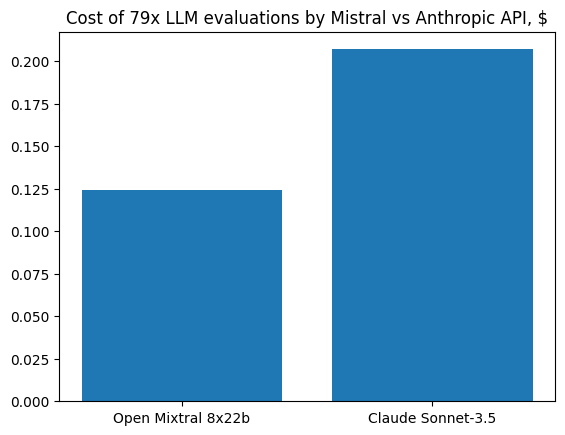

In [7]:
import matplotlib.pyplot as plt

m_input = 0.000002
m_output = 0.000006
c_input = 0.000003
c_output = 0.000015

mistral_cost = (
    llm_mistral_claude.sum("mistral.usage.prompt_tokens") * m_input
    + llm_mistral_claude.sum("mistral.usage.completion_tokens") * m_output
)
claude_cost = (
    llm_mistral_claude.sum("claude.usage.input_tokens") * c_input
    + llm_mistral_claude.sum("claude.usage.output_tokens") * c_output
)

plt.bar(["Open Mixtral 8x22b", "Claude Sonnet-3.5"], [mistral_cost, claude_cost])
plt.title(f"Cost of {llm_mistral_claude.count()}x LLM evaluations by Mistral vs Anthropic API, $")
plt.show()

As we can see, the open-sourced Mixtral model is cheaper to run than Claude Sonnet.
Let us see how often these two models disagree:

Processed: 79 rows [00:00, 14130.06 rows/s]
Processed: 79 rows [00:00, 11070.46 rows/s]


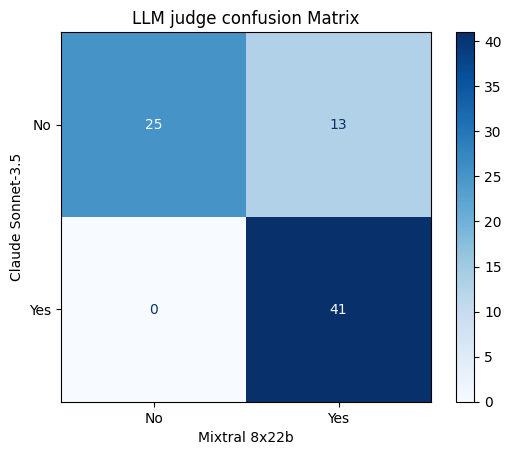

In [11]:
import json
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

new_chain = (
    DataChain.from_dataset("llm-mistral-claude")
    .map(mistral_rating=lambda mistral: json.loads(mistral.choices[0].message.content)["result"])
    .map(claude_rating=lambda claude: json.loads('{'+claude.content[0].text)["result"])
    .save()
)

y_mistral = new_chain.collect("mistral_rating")
y_claude = new_chain.collect("claude_rating")

cm = confusion_matrix(list(y_claude), list(y_mistral))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["No", "Yes"])
disp.plot(cmap=plt.cm.Blues)

plt.title("LLM judge confusion Matrix")
plt.xlabel("Mixtral 8x22b")
plt.ylabel("Claude Sonnet-3.5")

plt.show()

As we can see from the confusion matrix, the two LLMs only disagree when Mixtral gives it a pass, while Sonnet does not.
